# Convolutional Neural Network 구현

- mnist 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교 해본다.

##### 학습결과 시각화 함수 정의

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import numpy as np
import matplotlib.pyplot as plt

import os
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print(tf.__version__)

2.15.0


In [ ]:
# 결과 시각화 함수
def plot_result(hist, loss_min=None, loss_max=None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(hist.epoch, hist.history['loss'], label='Train Loss')
    plt.plot(hist.epoch, hist.history['val_loss'], label='Validation Loss')
    plt.title("Loss")
    if loss_min!=None and loss_max!=None:
        plt.ylim(loss_min, loss_max)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.epoch, hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.epoch, hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# mnist CNN 적용

##### data loading

In [3]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
print(train_image.shape, test_image.shape, train_label.shape, test_label.shape)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


##### 전처리, Dataset 생성
- X
    - uint8을 float32 타입으로 변경.
    - pixcel값 정규화: 0 ~ 1
    - Gray scale에 channel 축이 없는 경우 dummy 축을 늘려준다.
        - 영상처리 convolution layer(Conv2D)는 입력으로 3차원 (height, width, channel) 배열을 받는다.
- Y
    - OneHot Encoding
    - sparse_categorical_crossentropy 를 loss 함수로 사용할 경우는 OneHot Encoding 하지 않아도 된다.

In [4]:
# input 전처리
X_train = train_image.astype('float32')/255 # 타입변경 + scaling
X_train = X_train[..., np.newaxis] # 채널축(axis)를 추가. (28, 28)->(28,28,1)

X_test = test_image.astype('float32')/255
X_test = X_test[..., np.newaxis]

print(X_train.dtype, X_test.dtype)
print(X_train.shape, X_test.shape)

float32 float32
(60000, 28, 28, 1) (10000, 28, 28, 1)


##### 하이퍼파라미터, 변수 설정

In [ ]:
LEARNING_RATE = 0.001
N_EPOCH = 10
N_BATCH = 1000

N_TRAIN = X_train.shape[0]

## Model(Network) 정의
- Feature Extractor(backbone):Convolution Layer
    - block: Convolution + MaxPooling Layer
    - size(height, width) 는 줄이고 channel은 늘리는 방향으로 Layer들을 쌓는다.
    - convolution
        - size: 3 X 3
        - strides: 1
        - padding: same
    - max pooling
        - size: 2 X 2
        - strides: 2
        - 위와 같이 지정해 input의 size를 절반으로 줄인다.
- 추정기
    - Dense Layer 사용        
    - Flatten을 먼저 해야 한다. (Conv의 output-feature map- 3차원 배열)


In [ ]:
def get_mnist_cnn_model(lr=0.01):
    model = keras.Sequential()
    # Input Layer
    model.add(layers.InputLayer(input_shape=(28, 28, 1)))
             # (height, width, channel)  의 shape

    # Feature Extractor -> Convolution Block (Conv + MaxPool) 으로 정의
    model.add(layers.Conv2D(filters=16,      #필터 개수(추출할 특성 개수)
                           kernel_size=(3,3),#필터크기(h,w). h와w가 같을 경우 정수로 지정.
                           strides=(1,1),    #이동 크기(좌우,상하). 좌우==상하: 정수. default: 1
                           padding='same',   #padding지정: "same" - 입력과 같은 size로 출력되도록 padding을 알아서 추가. "valid": padding 적용안함.(default)
                           activation='relu' #활성함수
                           ))

    model.add(layers.MaxPooling2D(pool_size=(2, 2), # max값 추출 범위(h, w). h==w: 정수 (default:2 -> 1/4로 축소)
                                  strides=(2, 2),   # 이동 크기. (좌, 우). 보통 pool_size와 동일하게 잡는다.(겹치지 않게한다. default)
                                  padding="same")) # "same" : 값을 추출할 영역이 pool_size보다 작아도 추출.
                                                   # "valid": 값을 추출할 영역이 pool_size보다 작으면 추출 안한다.(default)                                  ))

    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Flatten())

    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=256, activation='relu'))

    # 출력 Layer
    model.add(layers.Dropout(0.3))
    ## 다중분류: unit수: class 개수, activation: softmax(class별 확률)
    model.add(layers.Dense(units=10, activation='softmax', name='output_layer'))

    # 컴파일
    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

##### 모델 생성 및 확인

In [7]:
model = get_mnist_cnn_model(LEARNING_RATE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)          0

##### 학습

In [8]:
hist = model.fit(X_train,
                 train_label,
                 epochs=N_EPOCH + 10,
                 batch_size=N_BATCH,
                 validation_split=0.2)

Epoch 1/20
48/48 [==============================] - 7s 20ms/step - loss: 0.9854 - accuracy: 0.6914 - val_loss: 0.2020 - val_accuracy: 0.9423
Epoch 2/20
48/48 [==============================] - 1s 14ms/step - loss: 0.2110 - accuracy: 0.9350 - val_loss: 0.1071 - val_accuracy: 0.9665
Epoch 3/20
48/48 [==============================] - 1s 14ms/step - loss: 0.1388 - accuracy: 0.9568 - val_loss: 0.0824 - val_accuracy: 0.9741
Epoch 4/20
48/48 [==============================] - 1s 14ms/step - loss: 0.1053 - accuracy: 0.9666 - val_loss: 0.0691 - val_accuracy: 0.9793
Epoch 5/20
48/48 [==============================] - 1s 14ms/step - loss: 0.0903 - accuracy: 0.9713 - val_loss: 0.0664 - val_accuracy: 0.9793
Epoch 6/20
48/48 [==============================] - 1s 16ms/step - loss: 0.0803 - accuracy: 0.9749 - val_loss: 0.0525 - val_accuracy: 0.9836
Epoch 7/20
48/48 [==============================] - 1s 19ms/step - loss: 0.0679 - accuracy: 0.9788 - val_loss: 0.0520 - val_accuracy: 0.9836
Epoch 8/20
48

##### 결과시각화

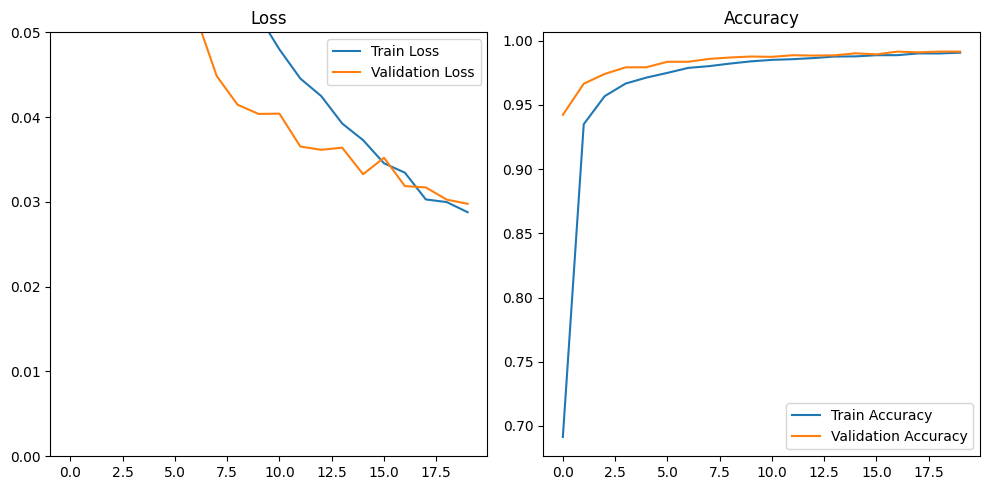

In [12]:
# plot_result(hist)
plot_result(hist, 0, 0.05)

##### 최종검증

In [13]:
loss, acc = model.evaluate(X_test, test_label)
print(f"최종평가 결과: loss-{loss}, accuracy-{acc}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0217 - accuracy: 0.9911
최종평가 결과: loss-0.021701280027627945, accuracy-0.991100013256073


## prediction error가 발생한 data 확인
- test dataset으로 예측한 결과중 틀린 것들을 확인해 본다.

In [14]:
pred = model.predict(X_test)
pred.shape
# (10000, 10)

313/313 [==============================] - 1s 2ms/step


(10000, 10)

In [15]:
label = np.argmax(pred, axis=-1)
print(label.shape)
# (10000,)

(10000,)


In [17]:
# 모델이 추론한 결과중 정답과 다른 것의 index를 조회
fail_idx = np.where(test_label  != label)[0]
fail_idx.size
# fail_idx

89

##### confusion matrix 확인

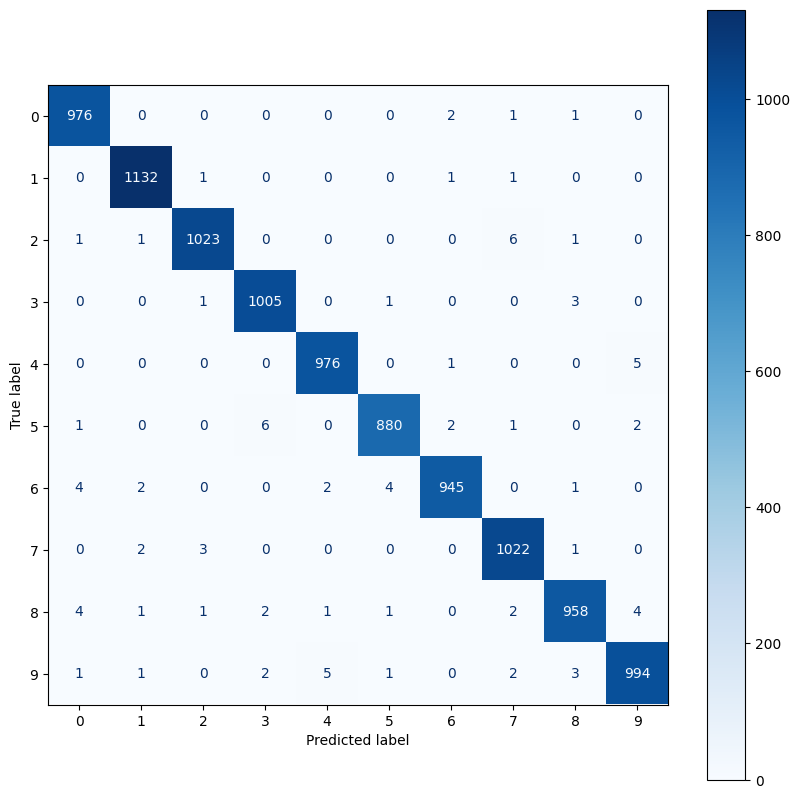

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(10,10))
ax = plt.gca()

cm = confusion_matrix(test_label, label)
dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap="Blues", ax=ax)
plt.show()

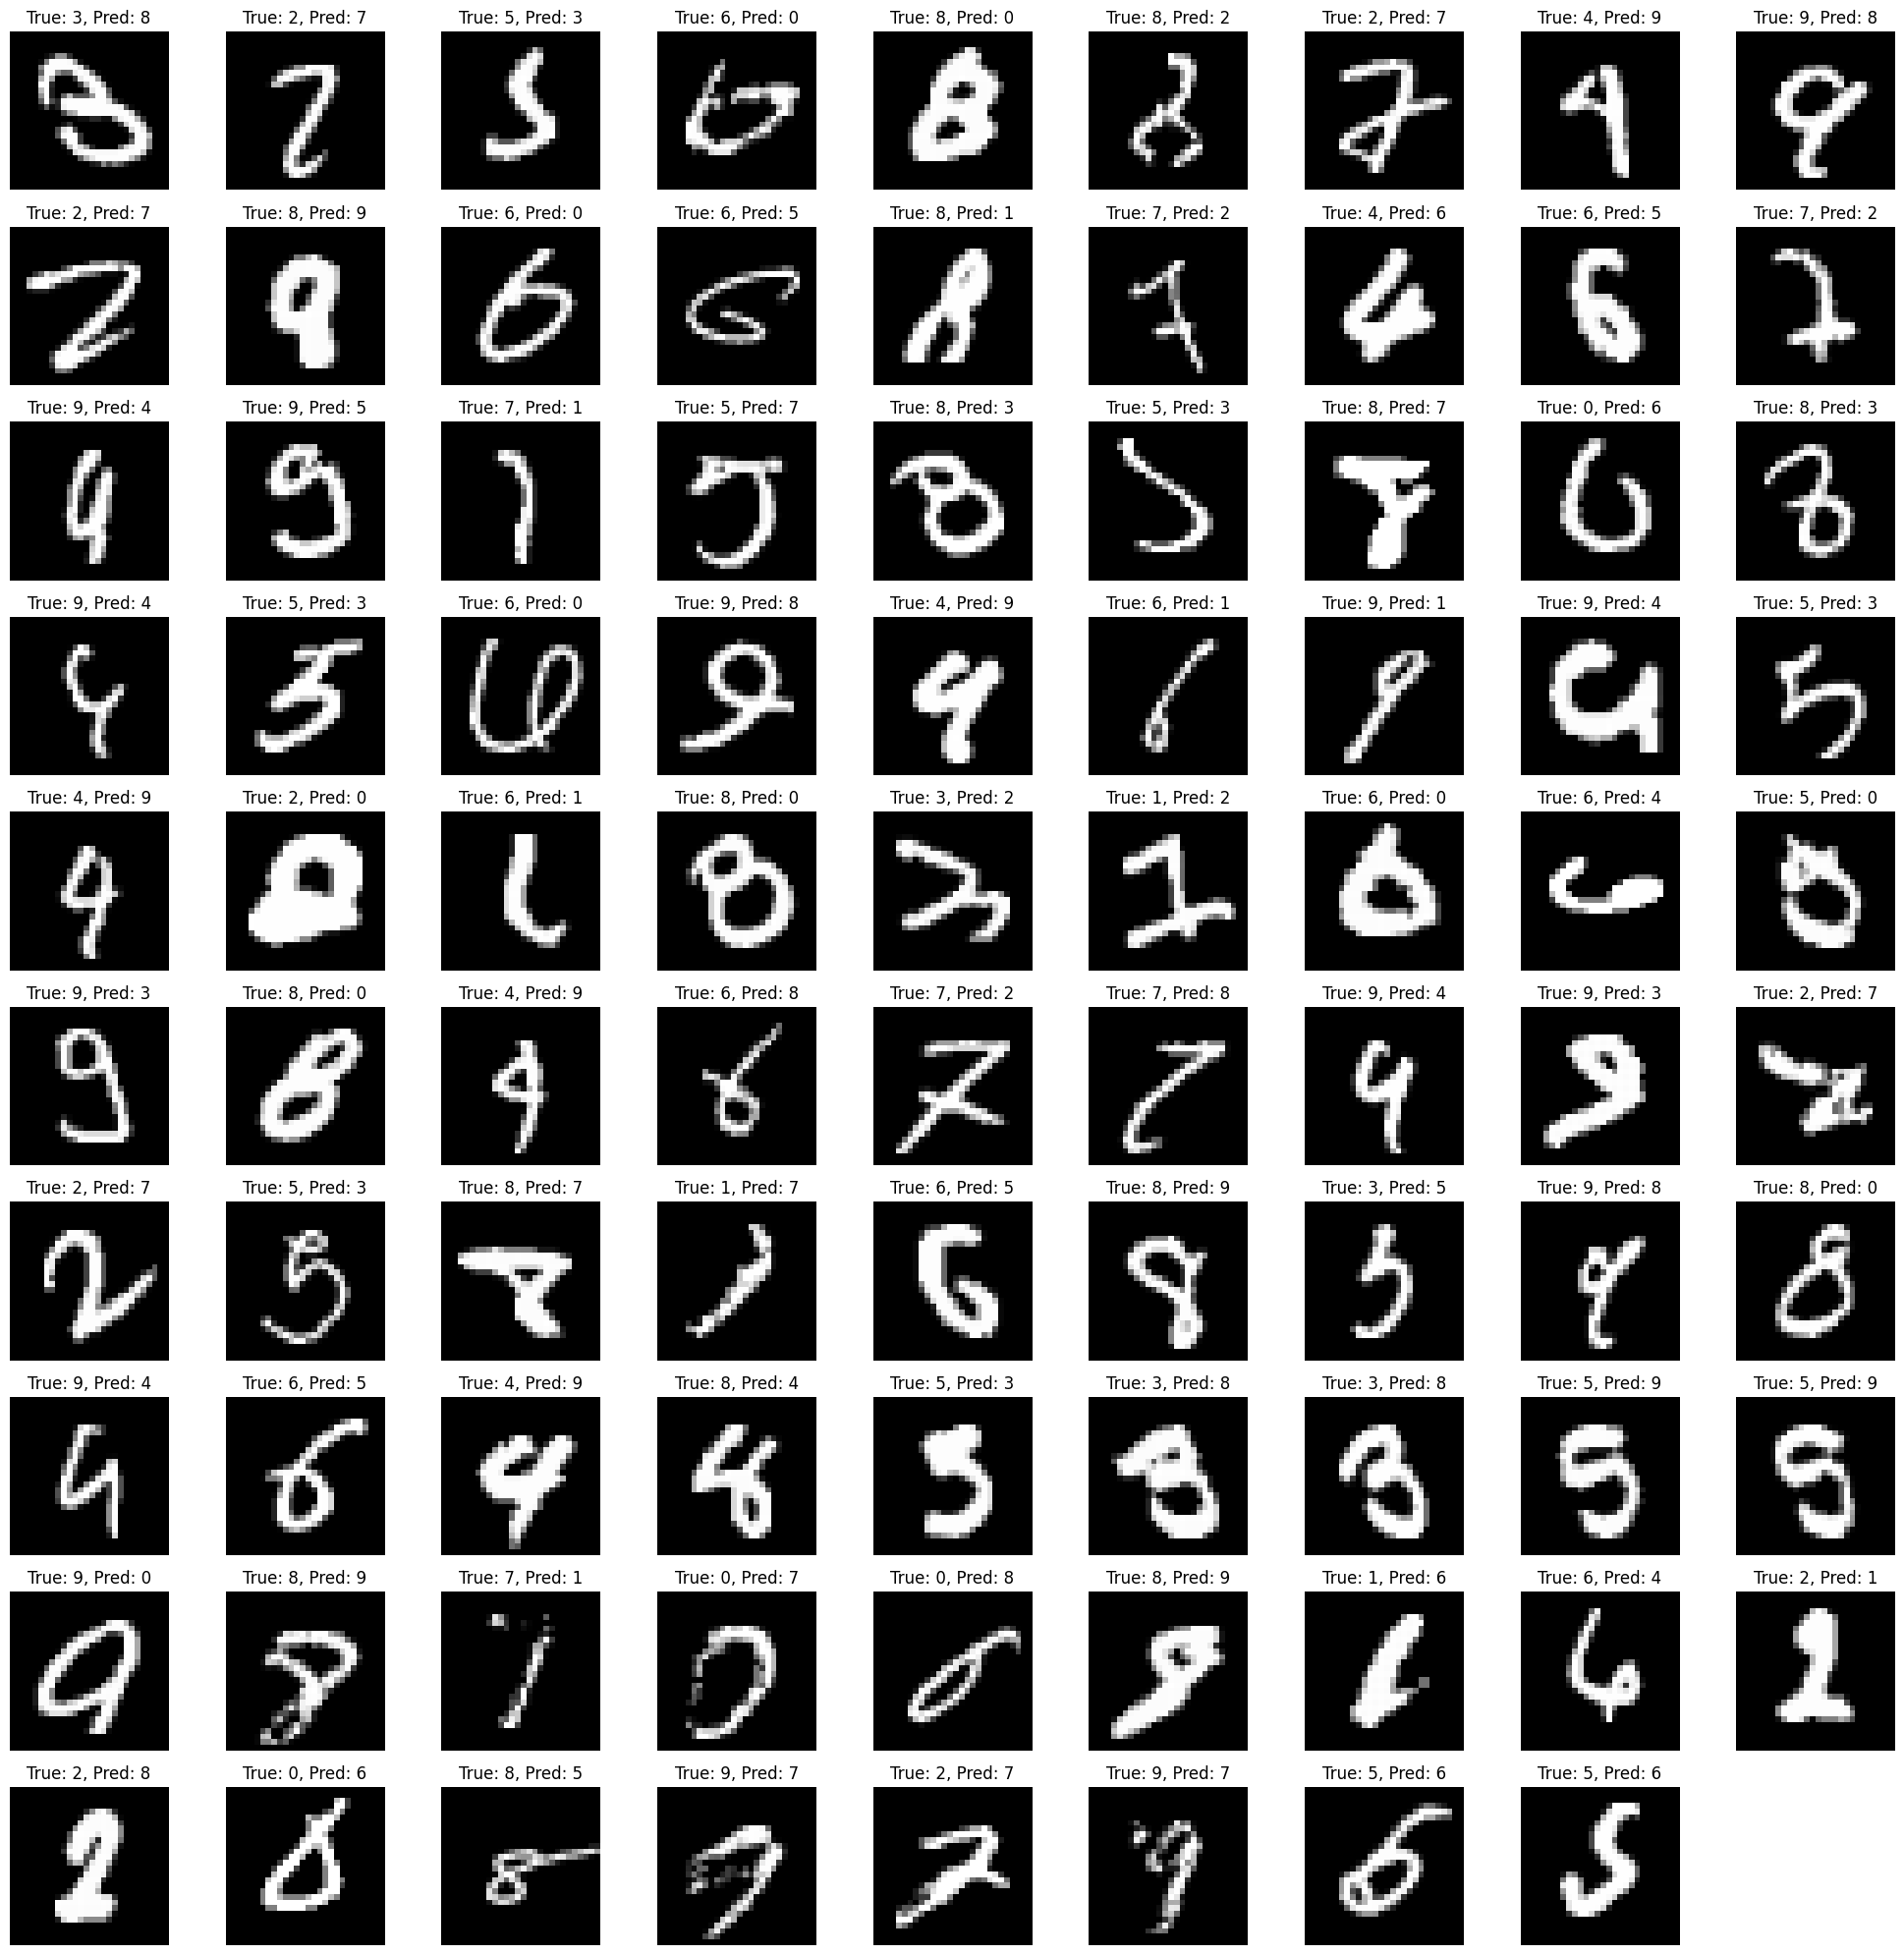

In [19]:
# 틀린 이미지들 중 일부 시각화
plt.figure(figsize=(20, 20))
rows = int(np.ceil(fail_idx.size/10))

for i in range(int(fail_idx.size)):
    error_idx = fail_idx[i]
    pred_label = label[error_idx]
    true_label = test_label[error_idx]
    img = test_image[error_idx]

    plt.subplot(10, rows, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# 딥러닝 모델 저장

- **무엇을 저장할 지**
    1. Train이 끝난 모델의 파라미터만 저장
    1. 모델 구조와 파라미터 모두 저장

- **저장시점**
    1. Train 완료된 모델을 저장
    1. Callback을 이용해 Train 도중 가장 성능이 좋은 시점의 모델을 저장

## 텐서플로 저장 형식
- checkpoint
    - 모델의 weight를 저장하기 위한 타입
- SavedModel
    - 모델의 구조와 파라미터들을 모두 저장하는 타입

## 학습한 Weight (파라미터)만 저장하기(save), 불러오기(load)
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장
    - `model.save_weights("저장경로")`
- 불러오기
    - 새로 생성한 모델의 초기파라미터를 저장한 파라미터로 덮어씌운다. (load)
    - `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`
        - 또는 파일 확장자를 h5로 지정한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 저장할 디렉토리 생성
import os
SAVE_ROOT_PATH = "/content/drive/MyDrive/my_model"
SAVE_MODEL_PATH = os.path.join(SAVE_ROOT_PATH, 'saved_models')
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)
print(os.path.isdir(SAVE_MODEL_PATH)) # 디렉토리가 있는지 여부

In [ ]:
# MODEL의 파라미터들만 저장.(checkpoints) => model.save_weight(저장파일경로)
MNIST_WEIGHTS_DIR_PATH = os.path.join(SAVE_MODEL_PATH, 'mnist_cnn_weights')
os.makedirs(MNIST_WEIGHTS_DIR_PATH, exist_ok=True)
MNIST_WEIGHTS_FILE_PATH = os.path.join(MNIST_WEIGHTS_DIR_PATH, 'ckpt')
print(MNIST_WEIGHTS_FILE_PATH)
# /content/drive/MyDrive/my_model/saved_models/mnist_cnn_weights/ckpt

In [ ]:
model.save_weights(MNIST_WEIGHTS_FILE_PATH)

In [26]:
# 저장된 WEIGHT를 LOADING해서 모델을 RESTORE
# 1. 모델을 생성
saved_model = get_mnist_cnn_model(LEARNING_RATE)
saved_model.evaluate(X_test, test_label)

313/313 [==============================] - 2s 4ms/step - loss: 2.3032 - accuracy: 0.1166


[2.3031561374664307, 0.11659999936819077]

In [27]:
#2. 생성한 모델에 읽어온(loading) weight를 덮어씌운다.
saved_model.load_weights(MNIST_WEIGHTS_FILE_PATH)
saved_model.evaluate(X_test, test_label)
# [0.021701280027627945, 0.991100013256073]

313/313 [==============================] - 1s 3ms/step - loss: 0.0217 - accuracy: 0.9911


[0.021701280027627945, 0.991100013256073]

## 모델(모델구조 + weights) 저장하기, 불러오기
- https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ko
- 저장
    - `model.save('저장할디렉토리')`
        - 저장할 파일경로가 아니라 **디렉토리 경로를** 지정한다.
- 불러오기
    - `tf.keras.models.load_model('저장된디렉토리')`
- 저장 형식
    - Tensorflow **SavedModel** 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')`
        - 또는 파일의 확장자를 h5로 지정한다.

In [28]:
# 모델자체를 저장: 저장할 디렉토리 경로를 지정.
# 파라미터를 저장: 저장할 파일경로.
MNIST_MODEL_PATH = os.path.join(SAVE_MODEL_PATH, 'mnist_cnn_model')
# MNIST_MODEL_PATH = os.path.join(SAVE_MODEL_PATH, 'mnist_model')
MNIST_MODEL_PATH
# /content/drive/MyDrive/my_model/saved_models/mnist_cnn_model

'/content/drive/MyDrive/my_model/saved_models/mnist_cnn_model'

In [ ]:
model.save(MNIST_MODEL_PATH)

In [30]:
saved_model2 = tf.keras.models.load_model(MNIST_MODEL_PATH)
saved_model2.evaluate(X_test, test_label)
# [0.021701280027627945, 0.991100013256073]

313/313 [==============================] - 1s 4ms/step - loss: 0.0217 - accuracy: 0.9911


[0.021701280027627945, 0.991100013256073]

## Callback을 사용한 모델 저장(training 중 저장) 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- Keras는 학습하는 도중 호출되는 다양한 콜백 클래스들을 제공한다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- ### ModelCheckpoint
    - 각 epoch 마다 학습한 모델과 weight(또는 weight만)를 저장한다.
    - 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight만 저장할 수 있다.
    - 주요 파라미터
        - `save_weights_only=True`: True: 파라미터(weight)만 저장한다. False: 모델구조와 파라미터 모두 저장한다.
        - `save_best_only=True`: 학습중 성능이 개선될 때만 저장한다. (False:기본값 - 모든 에폭마다 저장한다.)
- ### EarlyStopping
    - Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈추는 callback
    - 주요 파라미터
        - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
        - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다.

- **callback 객체들을 리스트로 묶은 뒤 fit()의 callbacks 매개변수에 전달한다.**

In [ ]:
import tensorflow as tf

In [ ]:
#  모델생성
model2 = get_mnist_cnn_model(LEARNING_RATE)

In [33]:
# 모델 저장 경로
SAVE_PATH = os.path.join(SAVE_MODEL_PATH, 'MNIST_MODEL_CALLBACK')

# 모델 저장 callback
mc_callback = keras.callbacks.ModelCheckpoint(
            filepath=SAVE_PATH,   # 저장경로
            save_best_only=True,  # 성능이 개선될때만 저장할지 여부.
            monitor='val_loss',   # 평가지표. (이 성능이 개선되면 저장.)
            verbose=1
            )
# 조기종료 callback
early_stop_callback = keras.callbacks.EarlyStopping(
            monitor='val_loss',  # 종료기준 성능지표
            patience=5,          # 성능지표가 개선될때 까지 몇 에폭 기달릴지 지정.
            verbose=1
            )

hist = model2.fit(X_train, train_label, epochs=100, batch_size=N_BATCH, validation_split=0.2,
                  callbacks=[mc_callback, early_stop_callback])

Epoch 1/100
45/48 [===========================>..] - ETA: 0s - loss: 1.0602 - accuracy: 0.6652
Epoch 1: val_loss improved from inf to 0.20135, saving model to /content/drive/MyDrive/my_model/saved_models/MNIST_MODEL_CALLBACK
48/48 [==============================] - 4s 55ms/step - loss: 1.0148 - accuracy: 0.6798 - val_loss: 0.2014 - val_accuracy: 0.9402
Epoch 2/100
45/48 [===========================>..] - ETA: 0s - loss: 0.2088 - accuracy: 0.9350
Epoch 2: val_loss improved from 0.20135 to 0.10419, saving model to /content/drive/MyDrive/my_model/saved_models/MNIST_MODEL_CALLBACK
48/48 [==============================] - 2s 38ms/step - loss: 0.2063 - accuracy: 0.9358 - val_loss: 0.1042 - val_accuracy: 0.9689
Epoch 3/100
45/48 [===========================>..] - ETA: 0s - loss: 0.1319 - accuracy: 0.9586
Epoch 3: val_loss improved from 0.10419 to 0.07944, saving model to /content/drive/MyDrive/my_model/saved_models/MNIST_MODEL_CALLBACK
48/48 [==============================] - 2s 36ms/step - l

In [34]:
model2.evaluate(X_test, test_label)
# [0.01940314471721649, 0.9933000206947327]

313/313 [==============================] - 1s 3ms/step - loss: 0.0194 - accuracy: 0.9933


[0.01940314471721649, 0.9933000206947327]

In [35]:
# 저장된 모델을 loading
saved_model4 = models.load_model(SAVE_PATH)
saved_model4.evaluate(X_test, test_label)
# [0.02206464298069477, 0.9922000169754028]

313/313 [==============================] - 1s 3ms/step - loss: 0.0221 - accuracy: 0.9922


[0.02206464298069477, 0.9922000169754028]

In [37]:
# weight 만 저장하도록 callback 설정
model3 = get_mnist_cnn_model(LEARNING_RATE)

SAVE_PATH = os.path.join(SAVE_MODEL_PATH, 'MNIST_WEIGHTS_CALLBACK/ckpt')
mc_callback = keras.callbacks.ModelCheckpoint(filepath=SAVE_PATH,
                                              save_best_only=True,
                                              monitor='val_loss',
                                              verbose=1,
                                              save_weights_only=True, # 파라미터만 저장.
                                              )

early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    verbose=1
                                                    )

hist = model3.fit(X_train, train_label, epochs=100, batch_size=N_BATCH, validation_split=0.2,
                  callbacks=[mc_callback, early_stop_callback])

Epoch 1/100
46/48 [===========================>..] - ETA: 0s - loss: 1.0084 - accuracy: 0.6770
Epoch 1: val_loss improved from inf to 0.20491, saving model to /content/drive/MyDrive/my_model/saved_models/MNIST_WEIGHTS_CALLBACK/ckpt
48/48 [==============================] - 3s 24ms/step - loss: 0.9796 - accuracy: 0.6863 - val_loss: 0.2049 - val_accuracy: 0.9390
Epoch 2/100
45/48 [===========================>..] - ETA: 0s - loss: 0.2172 - accuracy: 0.9314
Epoch 2: val_loss improved from 0.20491 to 0.10761, saving model to /content/drive/MyDrive/my_model/saved_models/MNIST_WEIGHTS_CALLBACK/ckpt
48/48 [==============================] - 1s 16ms/step - loss: 0.2150 - accuracy: 0.9320 - val_loss: 0.1076 - val_accuracy: 0.9675
Epoch 3/100
45/48 [===========================>..] - ETA: 0s - loss: 0.1365 - accuracy: 0.9569
Epoch 3: val_loss improved from 0.10761 to 0.08100, saving model to /content/drive/MyDrive/my_model/saved_models/MNIST_WEIGHTS_CALLBACK/ckpt
48/48 [=============================

In [38]:
saved_model5 = get_mnist_cnn_model(LEARNING_RATE)
saved_model5.load_weights(SAVE_PATH)

# [0.02096715196967125, 0.9926000237464905]

In [39]:
saved_model5.evaluate(X_test, test_label)

313/313 [==============================] - 1s 3ms/step - loss: 0.0210 - accuracy: 0.9926


[0.02096715196967125, 0.9926000237464905]